# Classification. Linear models and KNN. Part 2

In [19]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [21]:
PATH='data/'

In [22]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [23]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [24]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [25]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [28]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

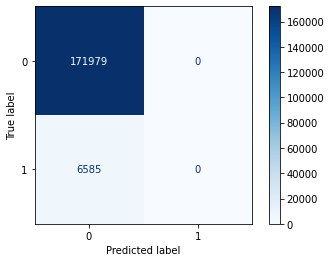

In [29]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [30]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

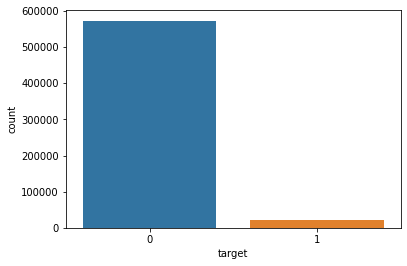

In [31]:

sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [32]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

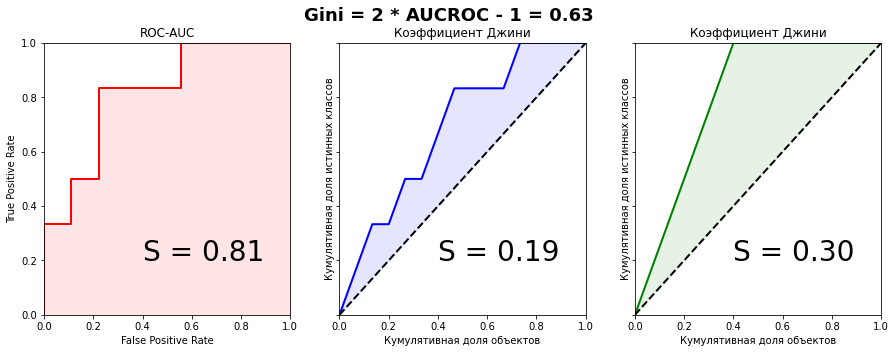

In [33]:
# Использованы материалы https://habr.com/ru/company/ods/blog/350440/
# Пара графиков для наглядности, что такое GINI и AUC ROC
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.interpolate import interp1d
from scipy.integrate import quad

actual = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
predict = [0.9, 0.3, 0.8, 0.75, 0.65, 0.6, 0.78, 0.7, 0.05, 0.4, 0.4, 0.05, 0.5, 0.1, 0.1]


data = zip(actual, predict)
sorted_data = sorted(data, key=lambda d: d[1], reverse=True)
sorted_actual = [d[0] for d in sorted_data]

cumulative_actual = np.cumsum(sorted_actual) / sum(actual)
cumulative_index = np.arange(1, len(cumulative_actual)+1) / len(predict)
cumulative_actual_perfect = np.cumsum(sorted(actual, reverse=True)) / sum(actual)

x_values = [0] + list(cumulative_index)
y_values = [0] + list(cumulative_actual)
y_values_perfect = [0] + list(cumulative_actual_perfect)

f1, f2 = interp1d(x_values, y_values), interp1d(x_values, y_values_perfect)
S_pred = quad(f1, 0, 1, points=x_values)[0] - 0.5
S_actual = quad(f2, 0, 1, points=x_values)[0] - 0.5

aucroc = roc_auc_score(actual, predict)
gini_score = 2*roc_auc_score(actual, predict)-1
fpr, tpr, t = roc_curve(actual, predict)

fig, ax = plt.subplots(nrows=1,ncols=3, sharey=True, figsize=(15, 5))
fig.suptitle('Gini = 2 * AUCROC - 1 = {:0.2f}\n\n'.format(gini_score),fontsize = 18, fontweight='bold')
ax[0].plot([0]+fpr.tolist(), [0]+tpr.tolist(), lw = 2, color = 'red')
ax[0].fill_between([0]+fpr.tolist(), [0]+tpr.tolist(), color = 'red', alpha=0.1)
ax[0].text(0.4,0.2,'S = {:0.2f}'.format(aucroc),fontsize = 28)
ax[1].plot(x_values, y_values, lw = 2, color = 'blue')
ax[1].fill_between(x_values, x_values, y_values, color = 'blue', alpha=0.1)
ax[1].text(0.4,0.2,'S = {:0.2f}'.format(S_pred),fontsize = 28)
ax[2].plot(x_values, y_values_perfect, lw = 2, color = 'green')
ax[2].fill_between(x_values, x_values, y_values_perfect, color = 'green', alpha=0.1)
ax[2].text(0.4,0.2,'S = {:0.2f}'.format(S_actual),fontsize = 28)

ax[0].set(title='ROC-AUC', xlabel='False Positive Rate', 
              ylabel='True Positive Rate', xlim=(0, 1), ylim=(0, 1))
for i in range(1,3):
    ax[i].plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    ax[i].set(title='Коэффициент Джини', xlabel='Кумулятивная доля объектов', 
              ylabel='Кумулятивная доля истинных классов', xlim=(0, 1), ylim=(0, 1))
plt.show();

Введем несколько обозначений:
- $n_0$ - количество объектов класса (0) - отрицательный ответ
- $n_1$ - количество объектов класса (1) - положительный ответ
- $TP$ или $TP(t)$ - функция вероятности верного положительного ответа от порогового значения 
- $FP$ или $FP(t)$ - функция вероятности неверного положительного ответа от порогового значения 
- $TPR=\frac{TP}{n_1}$ - доля верных положительных ответов
- $FPR=\frac{TP}{n_0}$ - доля неверных положительных ответов

Как видно из графиков выше, да и самого определения AUC ROC

$$AUC ROC=\int_0^1 TPR\,dFPR = \int_0^1 \frac{TP}{n_1}\,d\frac{FP}{n_0}=\frac{1}{n_1\cdot n_0} \int_0^{n_0} TP\,dFP$$

Нормализованный GINI выглядит так:
$$GINI=\frac{GINI_{model}}{GINI_{perfect}}$$

${GINI_{perfect}}$ - это площадь треугольника, где основание - доля истинных отрицательных ответов в общем количестве ответов, а высота - 1, т.е. $${GINI_{perfect}}= \frac{1}{2}\cdot\frac{n_0}{n_0 + n_1}$$

В свою очередь
$${GINI_{model}} = \int_0^1 TPR\, d\frac{TP+FP}{n_1+n_0} - 0.5$$

Немного преобразований
$${GINI_{model}} = \frac{1}{n_1\cdot(n_1+n_0)}\cdot\int_0^{n_1 + n_0} TP\, d(FP+TP)- 0.5$$



Возвращаемся к нормализованному GINI
$${GINI} = \frac{\frac{1}{n_1\cdot(n_1+n_0)}\cdot\int_0^{n_1 + n_0} TP\, d(FP+TP)- 0.5}{\frac{1}{2}\cdot\frac{n_0}{n_0 + n_1}}$$

$${GINI} = \frac{2}{n_0\cdot n_1}\cdot\int_0^{n_1+n_0} TP\, d(FP+TP) - \frac{n_0}{n_0} - \frac{n_1}{n_0}$$

$${GINI} = \frac{2}{n_0\cdot n_1}\cdot\int_0^{n_0} TP\, dFP + \frac{2}{n_0\cdot n_1}\cdot\int_0^{n_1} TP\, dTP - \frac{n_1}{n_0} - 1 $$

Первый интеграл - это $2\cdot AUC ROC$ (первая формула из доказательства). Второй интеграл можно взять
$${GINI} = 2\cdot AUC ROC + \frac{2}{n_0\cdot n_1}\cdot \frac{n_1^2}{2}- \frac{n_1}{n_0} - 1 $$

Сократив члены получаем традиционную формулу связи AUC ROC и GINI
$${GINI} = 2\cdot AUC ROC - 1 $$

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

**Thoughts:** For imbalaced dataset F1-score, Precision and Recall metrics might be useful. It depends on which type of error has higher price (false-positive or false-negative)

Let's calculate the Normalized Gini Coefficient:

In [34]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [35]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [36]:
insurance_data_y = insurance_data['target']

In [37]:
# Split data to prepare combined dataset
positive_data = insurance_data[insurance_data['target'] == 1] 
negative_data = insurance_data[insurance_data['target'] == 0]

In [38]:
# Mix positive and negative data to has approximately uniform distribution
mid_sample = positive_data.append(
    positive_data).append(
    positive_data).append(
    positive_data).append(
    positive_data).append(
    positive_data).append(
    positive_data).append(
    positive_data).append(
    positive_data).append(
    positive_data).append(negative_data.sample(n=round(positive_data['target'].count() *9.9), random_state=61)
                         ).sample(frac=1)

In [39]:
# Select features from model
tmp_X = insurance_data.drop(columns=['target'])
tmp_y = insurance_data['target']

selector = SelectFromModel(
     LogisticRegression(solver='liblinear', penalty='l1', random_state=42)
).fit(tmp_X, tmp_y)
print(tmp_X.columns[selector.get_support()]) 

Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin', 'ps_ind_17_bin',
       'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13',
       'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03',
       'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08',
       'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13',
       'ps_calc_14', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin',
       'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin'],
      dtype='object')


In [41]:
# Use mixed data as train/test datasets
y = mid_sample['target']
X = mid_sample.drop(columns=['target'])

# Use features from previous step
features_to_use = ['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin', 'ps_ind_17_bin',
       'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13',
       'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03',
       'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08',
       'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13',
       'ps_calc_14', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin',
       'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']

X = X[features_to_use]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

# Some preparation for pipeline
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder (handle_unknown = 'ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ])

In [49]:
# Do some random_state pick up
df = pd.DataFrame([{'x': -1, 'gini': 0, 'acc': 0}]);
for x in np.arange(10, 100, 7):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=x)

    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
             ('classifier', LogisticRegression(solver='liblinear',
                                            penalty='l1', random_state=x))])

    clf = pipeline.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_valid)[:, 1]
    df = df.append({'x': x, 'gini': gini_normalized(y_valid, y_pred), 
                    'acc': accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))},
                  ignore_index=True)
# Choose best GINI value
df[df['gini'] == df[1:]['gini'].max()]

,x,gini,acc
10,73.0,0.272202,0.596314


In [42]:
# Use random_state from previous step
x = 73

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=x)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
('classifier',  LogisticRegression(solver='liblinear', penalty='l1', random_state=x))
                          ])

# Fit the model
clf = pipeline.fit(X_train, y_train)

In [43]:
# Load test dataset and predict
insurance_data_test = pd.read_csv(os.path.join(PATH, 'porto', 'test.csv'))

X_ins_test = insurance_data_test.copy().set_index('id')
        
X_ins_test = X_ins_test[features_to_use]

y_ins_pred = clf.predict_proba(X_ins_test)[:,1]

output_porto = pd.DataFrame({'id': insurance_data_test.id, 'target': y_ins_pred})
output_porto.to_csv('porto_l1_9.9fold_rnd_73.csv', index=False)

Private score on kaggle: 0.26623

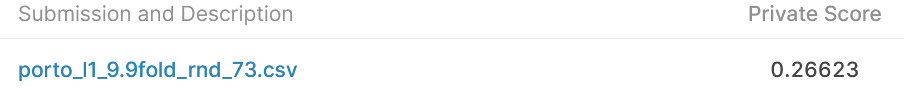